# ***CS 323 PROJECT: LOGISTIC REGRESSION IN MACHINE LEARNING***

## *BY: FARHA FERDOUS*

# Logistic Regression for Synthetic Data Classification  
In this project, I implement a Logistic Regression model applied to synthetic data classification.  

The project focuses on:  
- **Generating synthetic classification data** using `make_classification` and adding noise to assess model robustness.  
- **Training and tuning** a logistic regression model with hyperparameter optimization using grid search.  
- **Evaluating performance** based on multiple metrics, including time complexity, space complexity, and predictive accuracy.  
- **Benchmarking** the model's performance by analyzing its scalability with different data sizes and feature configurations.  
- **Visualizing results**, including confusion matrix, feature importance, and learning curves.  

## Logistic Regression Model Overview  

Logistic Regression is a linear classifier used for binary classification tasks. It models the probability that a given input belongs to a certain class, using a logistic function. The model's goal is to minimize the log-loss (cross-entropy loss) function during training, making it effective for classification tasks where the dependent variable is categorical.  

The model is trained on synthetic datasets with different numbers of features and sample sizes, and evaluated using metrics like accuracy, precision, and recall. This notebook also includes a discussion of hyperparameter tuning, particularly the regularization parameter `C`, and how it impacts model performance.


### IMPORTING LIBRARIES

Description:
*   These libraries are essential for generating datasets, scaling features, training a logistic regression model, evaluating performance, and plotting results.

In [30]:
# importing necessary libraries for data manipulation, model training, and evaluation

import numpy as np  # for numerical operations and array manipulations
import pandas as pd  # for data manipulation and analysis using DataFrames
import time  # for measuring execution time of code blocks
import matplotlib.pyplot as plt  # for data visualization (plots)
import seaborn as sns  # for enhanced data visualization (heatmaps, pairplots, etc.)
from sklearn.datasets import make_classification  # for generating synthetic classification datasets
from sklearn.preprocessing import StandardScaler  # for feature scaling (standardization)
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc, log_loss)  # for performance evaluation metrics
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression  # for logistic regression model
from sklearn.model_selection import (GridSearchCV, learning_curve,
                                     train_test_split, cross_val_score)  # for model selection, splitting, and cross-validation


### DEFINING THE CLASS
*   *Initialization* (__init__): Sets up the logistic regression model, data scaler, and other required components.
*   *Synthetic Data Generation* (generate_synthetic_data): Generates a synthetic dataset with optional class imbalance using make_classification.
*   *Noise Addition* (add_noise): Introduces Gaussian noise to simulate real-world imperfections in the data.
*   *Data Preprocessing* (preprocess_data): Scales the features and splits the data into training and testing sets.
*   *Model Training and Tuning* (train_and_tune_model): Uses grid search to optimize the hyperparameters of the logistic regression model.
*   *Grid Search Results* (print_grid_search_results): Displays the best hyperparameters and the results of the grid search cross-validation.
*   *Confusion Matrix Plot* (plot_confusion_matrix): Visualizes the confusion matrix to assess the classification performance.
*   *Feature Importance Plot* (plot_feature_importance): Plots the importance of each feature based on the model coefficients.
*   *Learning Curves* (plot_learning_curves): Plots the learning curves to visualize the model's performance with different training set sizes.
*   *Data Visualization* (visualize_data): Uses pair plots to visualize relationships between features and their impact on the target variable.
*   *Export Data* (export_data): Saves the synthetic dataset to a CSV file for future use.

In [31]:
class SyntheticDataPredictor:
    """
    logistic Regression implementation for synthetic data classification,
    with enhanced analysis and visualization capabilities
    """
    def __init__(self):
        self.model = SklearnLogisticRegression(solver='lbfgs', max_iter=10000, penalty='l2')
        self.scaler = StandardScaler()
        self.grid_search = None
        self.feature_names = None

    def generate_synthetic_data(self, n_samples=1000, n_features=10, n_informative=5,
                                 weights=None, random_state=42):
        """ generate synthetic classification data with optional class imbalance """
        X, y = make_classification(
            n_samples=n_samples, n_features=n_features, n_informative=n_informative,
            n_redundant=0, n_clusters_per_class=1, weights=weights, random_state=random_state
        )
        self.feature_names = [f"Feature_{i}" for i in range(X.shape[1])]
        return X, y

    def add_noise(self, X, noise_level=0.1):
        """ add Gaussian noise to synthetic data """
        noise = np.random.normal(0, noise_level, X.shape)
        return X + noise

    def preprocess_data(self, X, y, test_size=0.2):
        """ scale features and split into train/test sets """
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        return X_train_scaled, X_test_scaled, y_train, y_test

    def train_and_tune_model(self, X_train, y_train):
        """ perform grid search for hyperparameter tuning """
        param_grid = {
            'C': [0.1, 0.2, 1, 2, 10],
        }
        self.grid_search = GridSearchCV(self.model, param_grid, cv=5, scoring='f1')
        self.grid_search.fit(X_train, y_train)
        return self.grid_search

    def print_grid_search_results(self):
        """ print detailed results from grid search """
        print('Best Hyperparameters:', self.grid_search.best_params_)
        print("\nCross-validation results:")
        cv_results = self.grid_search.cv_results_
        for mean_score, std, params in zip(cv_results['mean_test_score'],
                                           cv_results['std_test_score'],
                                           cv_results['params']):
            print(f"Mean score: {mean_score:.4f}, "
                  f"Standard deviation: {std:.4f}, "
                  f"Hyperparameters: {params}")

    def plot_confusion_matrix(self, y_true, y_pred):
        """ plot confusion matrix using seaborn """
        unique_labels = np.unique(y_true)
        conf_mat = confusion_matrix(y_true, y_pred, labels=unique_labels)
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=unique_labels, yticklabels=unique_labels)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def plot_feature_importance(self):
        """ plot feature importance based on model coefficients """
        coefficients = self.grid_search.best_estimator_.coef_[0]
        coef_df = pd.Series(coefficients, index=self.feature_names)
        coef_df_sorted = coef_df.sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=coef_df_sorted, y=coef_df_sorted.index, color='blue')
        plt.title('Feature Importance (Descending Order)')
        plt.xlabel('Coefficient Magnitude')
        plt.ylabel('Feature Names')
        plt.show()

    def plot_learning_curves(self, X_train, y_train):
        """ plot learning curves to analyze model performance vs training size """
        train_sizes, train_scores, test_scores = learning_curve(
            self.grid_search.best_estimator_, X_train, y_train,
            cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, color='blue', marker='o',
                 label='Training Score')
        plt.fill_between(train_sizes, train_mean - train_std,
                         train_mean + train_std, alpha=0.15, color='blue')
        plt.plot(train_sizes, test_mean, color='green', linestyle='--',
                 marker='s', label='Cross-Validation Score')
        plt.fill_between(train_sizes, test_mean - test_std,
                         test_mean + test_std, alpha=0.15, color='green')
        plt.title('Learning Curves')
        plt.xlabel('Number of Training Samples')
        plt.ylabel('Accuracy Score')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

    def visualize_data(self, X, y):
        """ plot pairwise relationships of features and label distribution """
        df = pd.DataFrame(X, columns=self.feature_names)
        df['Target'] = y
        sns.pairplot(df, hue='Target')
        plt.show()

    def export_data(self, X, y, filename="synthetic_data.csv"):
        """ export synthetic dataset to CSV """
        df = pd.DataFrame(X, columns=self.feature_names)
        df['Target'] = y
        df.to_csv(filename, index=False)
        print(f"Dataset exported to {filename}.")


### GENERATING AND VISUALIZING SYNTHETIC DATA

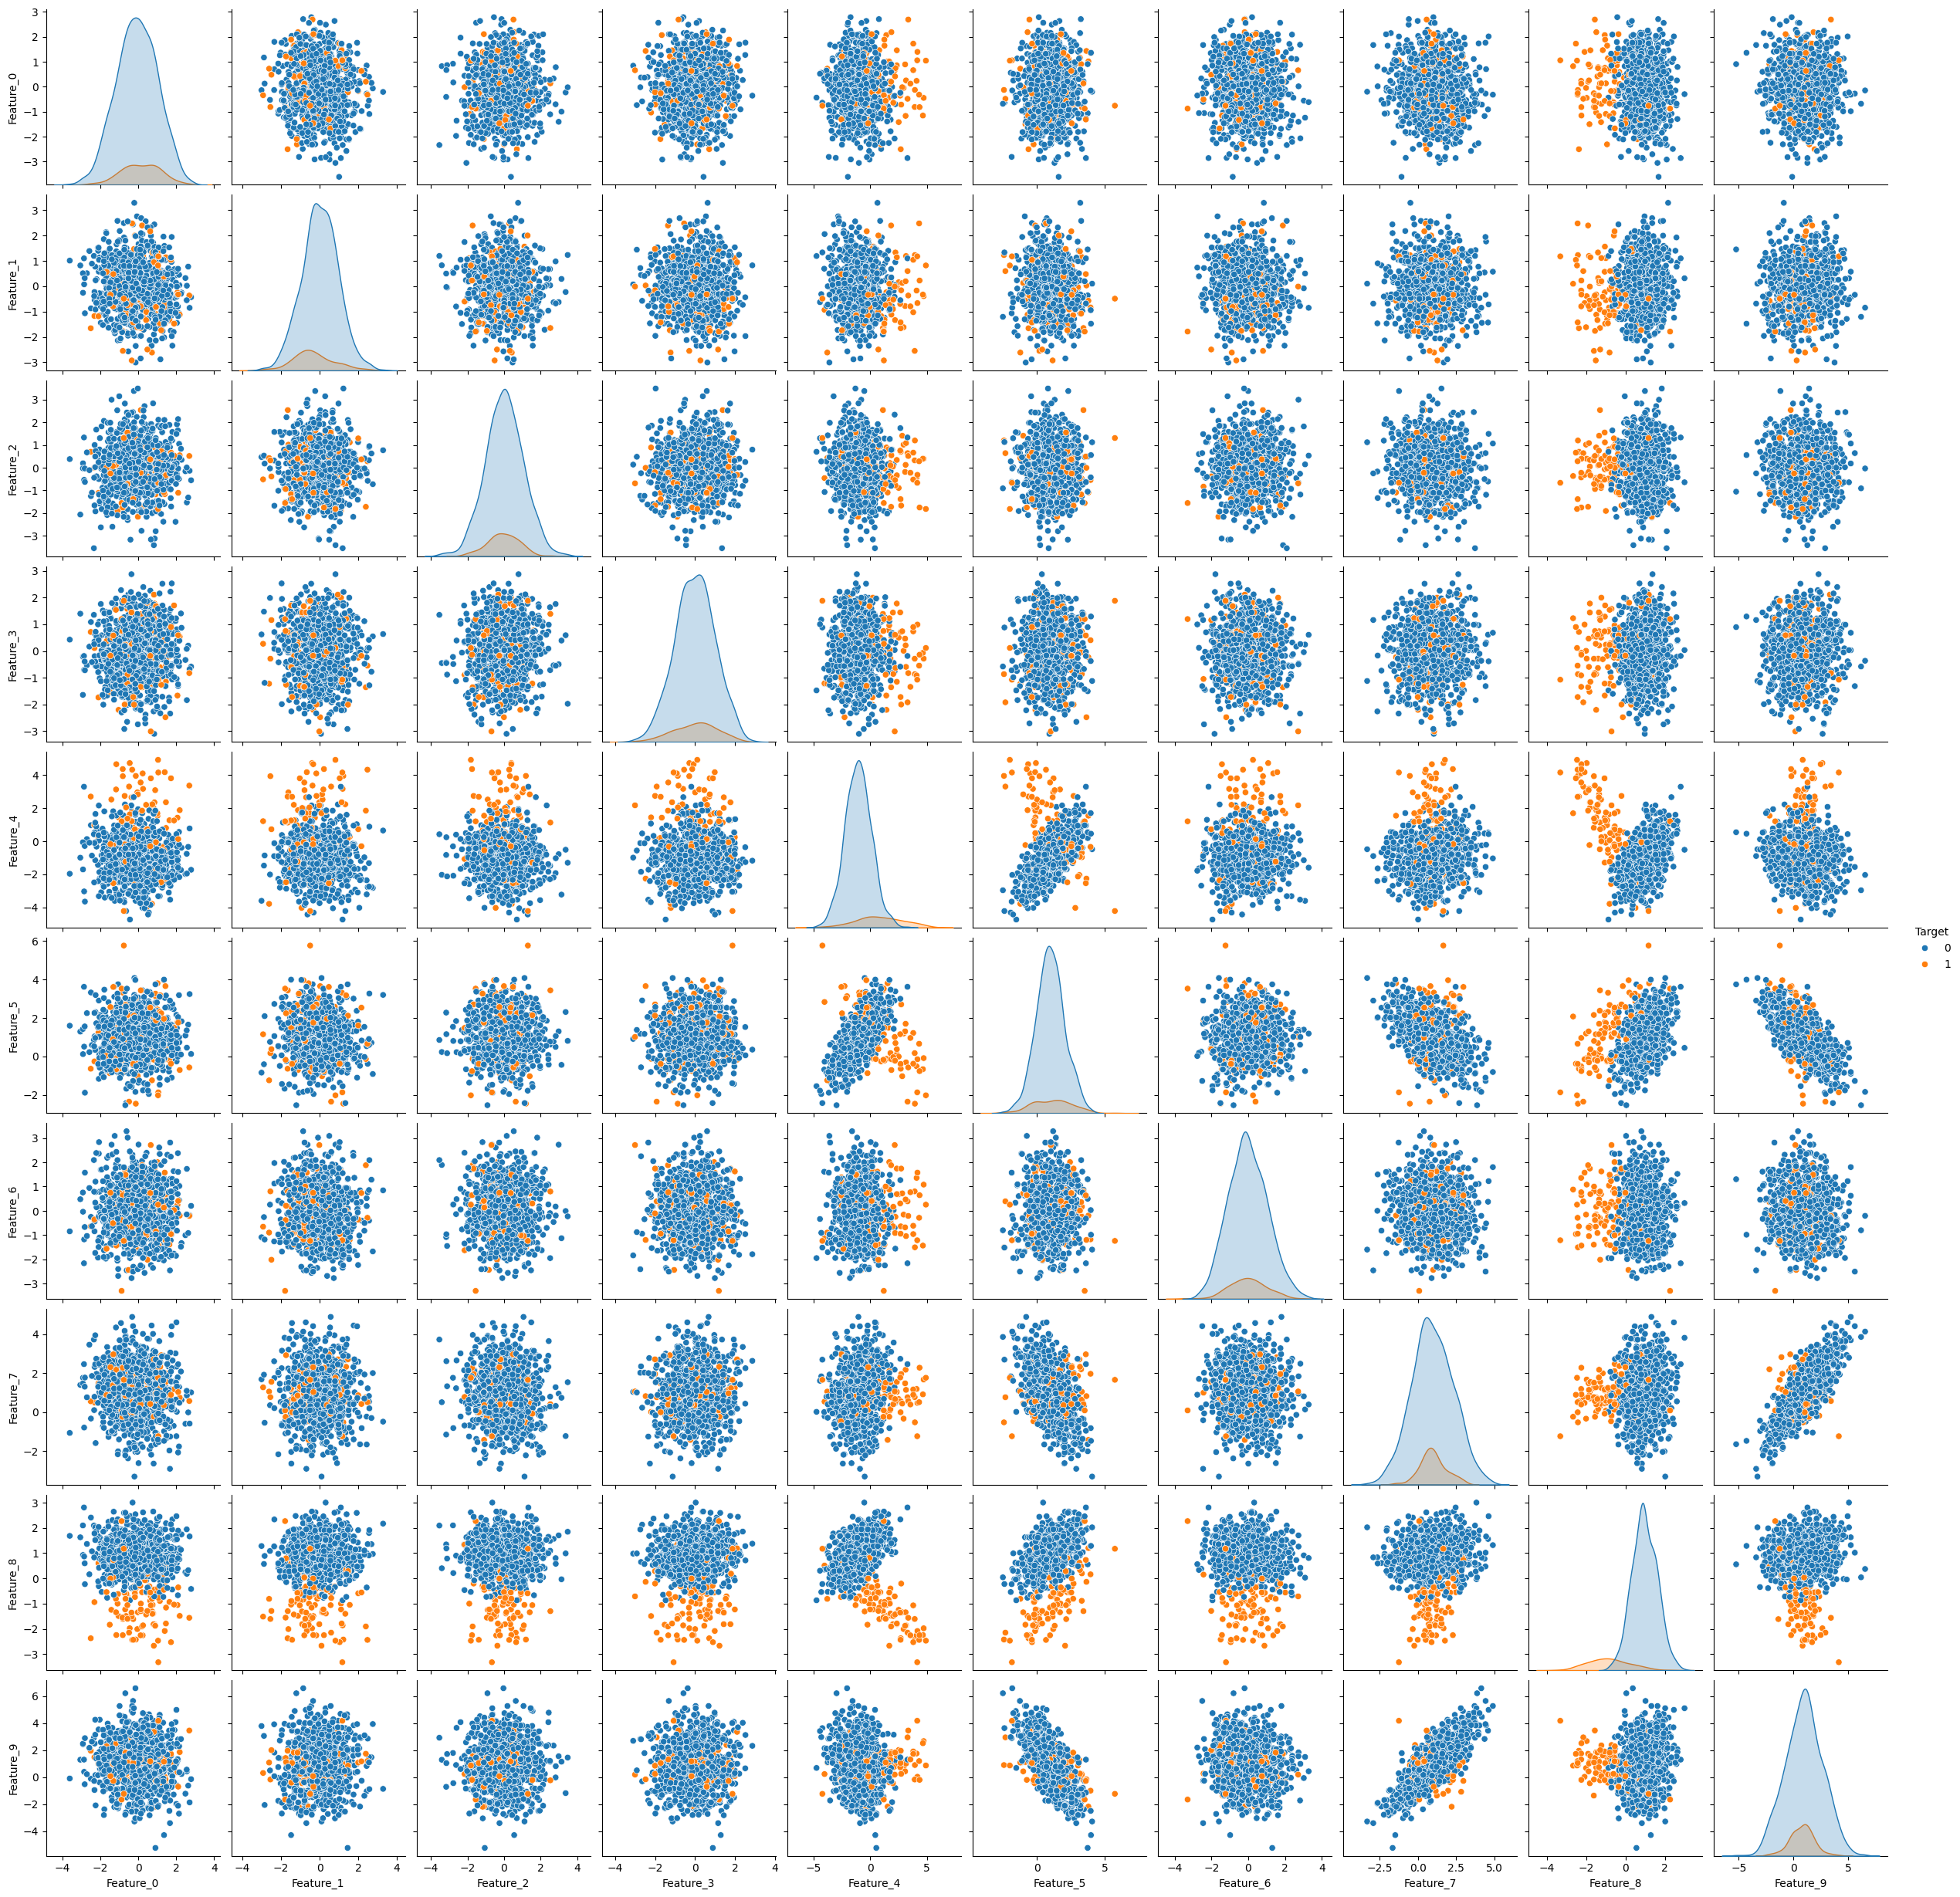

In [32]:
''' generate synthetic data with class imbalance and added noise, and then visualize the data using a pairplot. '''
# run the analysis
predictor = SyntheticDataPredictor()

# generate synthetic data with class imbalance and noise
X, y = predictor.generate_synthetic_data(weights=[0.9, 0.1])
X = predictor.add_noise(X, noise_level=0.05)

# visualize the synthetic data
predictor.visualize_data(X, y) # create a pairplot of the features and the target labels
                                # if the synthetic data has many features, the pairplot will look cluttered

### PREPROCESSING THE DATA

In [33]:
# preprocess the data
X_train, X_test, y_train, y_test = predictor.preprocess_data(X, y)

### TRAINING AND TUNING THE MODEL
*   This code preprocess the data, and will scale the features and split the dataset into training and testing sets.

In [34]:
# train and tune model
grid_search = predictor.train_and_tune_model(X_train, y_train)

### CLASSIFICATION REPORT AND CONFUSION MATRIX

*   The model's performance is strong with high accuracy (0.98) and a good balance between precision, recall, and F1-score for both classes, especially considering the class imbalance. The grid search shows that the model has been effectively tuned for optimal regularization (C=2)
*   While the results are great, we could still want to explore techniques like oversampling the minority class (class 1) or trying other classifiers (e.g., random forests or XGBoost) to handle the imbalance more robustly

Best Hyperparameters: {'C': 10}

Cross-validation results:
Mean score: 0.8039, Standard deviation: 0.0929, Hyperparameters: {'C': 0.1}
Mean score: 0.8277, Standard deviation: 0.0902, Hyperparameters: {'C': 0.2}
Mean score: 0.8630, Standard deviation: 0.0591, Hyperparameters: {'C': 1}
Mean score: 0.8694, Standard deviation: 0.0652, Hyperparameters: {'C': 2}
Mean score: 0.8763, Standard deviation: 0.0574, Hyperparameters: {'C': 10}

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       181
           1       1.00      0.89      0.94        19

    accuracy                           0.99       200
   macro avg       0.99      0.95      0.97       200
weighted avg       0.99      0.99      0.99       200



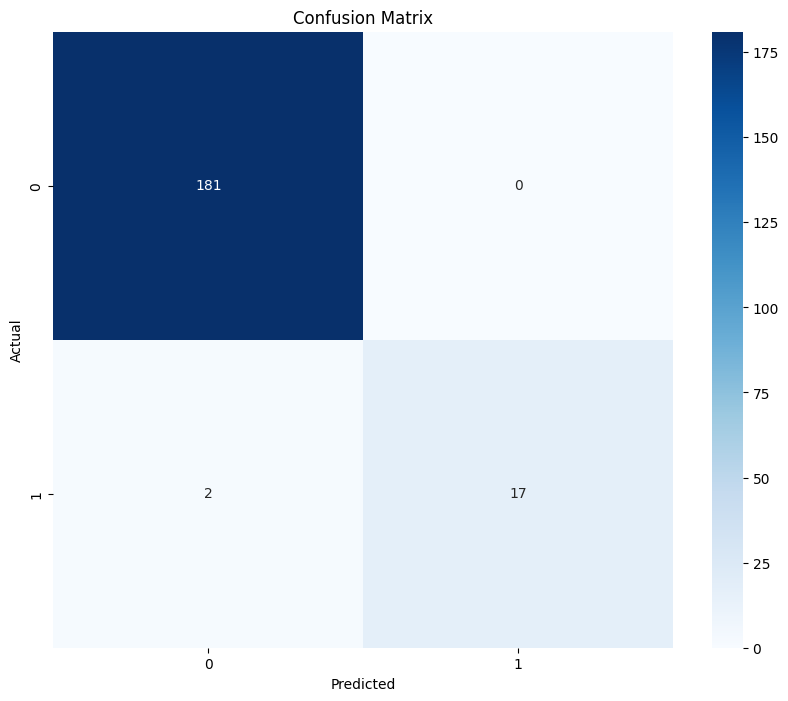

In [35]:
# make predictions
y_pred = grid_search.predict(X_test)

# print results
predictor.print_grid_search_results()
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
predictor.plot_confusion_matrix(y_test, y_pred)

### FEATURE IMPORTANCE
*   This feature importance result provides insights into how different features impact the model's prediction. Here it seems that feature 8 is driving the model toward class 0, while feature 5 is pushing it towards class 1. The remaining features have smaller or moderate impacts. Based on these results, we could focus on further analyzing these key features and possibly consider feature engineering or balancing techniques to improve performance, especially for the minority class (1).
*   Our features right now with both negative and positive coefficients exist suggests that the model is identifying both types of relationships (features that decrease and increase the probability of class 1). A mixture of positive and negative coefficients can be expected if there are problems involving a class imbalance or complex feature interactions.
*   In our case, since class 1 is underrepresented, it’s likely that the model compensates by focusing on these features to distinguish between the classes

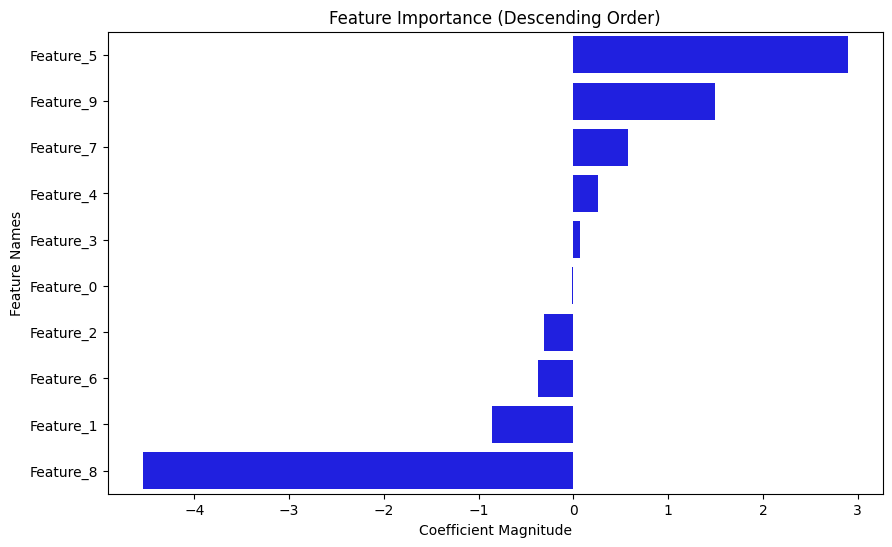

In [36]:
# feature importance
predictor.plot_feature_importance()

### LEARNING CURVES
*   *Training Score*: it starts high at 1.00 for 100 samples, and then slightly decreases as more samples are added.
As we are adding more training samples (from 100 to 700), the training score remains relatively stable and plateaus around 0.98 to 0.99. This suggests that the model is learning well and fitting the training data efficiently without significant overfitting
*   *Cross-Validation (CV) Score*: The CV score starts at 0.94-0.95 for 100 samples and increases gradually to 0.97+ for 400 samples. This means that the model's performance on unseen data is improving as more samples are introduced, which is indicating good performance. The CV score increases steadily as the training set grows, showing that the model is generalizing well.

The gradual increase in the CV score indicates that the model is improving its ability to generalize on unseen data as it gets more samples to learn from. This shows that the model is not just memorizing the training data but is truly learning patterns that generalize well.

The gap between the training score and CV score decreases indicates that the model was initially overfitting (perhaps memorizing specific patterns in a small training set), but as more data is provided, it starts reducing overfitting and generalizing better.

Logistic regression's strengths are evident in this learning curve: as more data is added, the model improves its generalization and reduces overfitting. This is characteristic of how linear models like logistic regression perform when given sufficient training data.
The convergence of the training and CV scores shows that the model is able to fit the data well and generalize to new, unseen samples — a hallmark of good performance in logistic regression.
The logistic regression model seems to have a well-calibrated decision boundary by the time the training set size reaches 700, with stable performance in both training and cross-validation. This makes the learning curve a good sign that the model is on track.

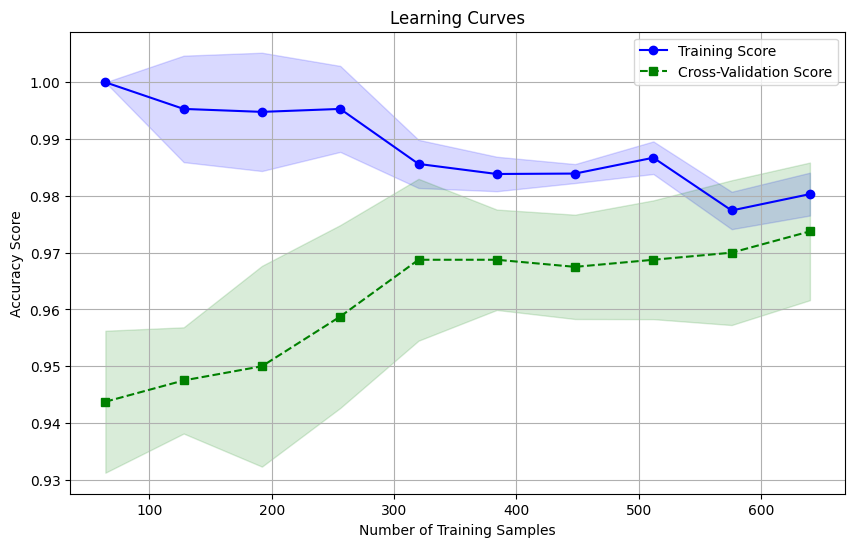

In [37]:
# learning curves
predictor.plot_learning_curves(X_train, y_train)

### EXPORTING THE DATA

In [38]:
# export synthetic data
predictor.export_data(X, y, "synthetic_data.csv")

Dataset exported to synthetic_data.csv.


# BENCHMARKING

This benchmarking code evaluates the performance of a Logistic Regression model on synthetic data while accounting for both empirical measurements (runtime, memory usage, and accuracy) and theoretical complexities (time and space).

The strengths of this approach lie in its comprehensive evaluation, dynamic test case handling, and scalability. By capturing multiple dimensions of performance—such as speed, memory efficiency, and predictive power—the benchmarking results provide a well-rounded analysis. The integration of both theoretical and empirical insights bridges the gap between expected and actual performance, offering a deeper understanding of the model's behavior. Additionally, varying test sizes allows for an exploration of how the model performs across different data proportions, which is crucial for assessing generalization and resource utilization.

The parameterized design of the code, including customizable elements like the number of samples and features, ensures adaptability for datasets of varying sizes. This flexibility not only facilitates a deeper examination of the model's performance under different conditions but also makes it easier to study its scalability, allowing for broader exploration and refinement.

### INSTALLING AND REINSTALLING THE NECESSARY AND REQUIRED LIBRARIES TO ENSURE WE HAVE EVERYTHING FOR BENCHMARKING

In [39]:
!pip install memory-profiler
!pip install scikit-learn
import numpy as np
import time
import memory_profiler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

### DEFINING THE BENCHMARK FUNCTION
*   Function Definition:The function benchmark_model_with_complexity() benchmarks a Logistic Regression model on synthetic data, with adjustable parameters for the number of samples (n_samples), features (n_features), and test sizes (test_sizes).

*   Synthetic Data Generation: make_classification() generates a synthetic dataset with a specified number of samples and features. The labels (y) and feature matrix (X) are generated for classification.

*   Loop Over Test Sizes: The for loop iterates over various test sizes (e.g., 0.2, 0.4, 0.6, 0.8) to simulate how the model performs with different proportions of training and test data.
In each iteration, the data is split into training and testing subsets using train_test_split(), where test_size defines the proportion of data used for testing.

*   Model Initialization: A Logistic Regression model is initialized with max_iter=10000, allowing more iterations for convergence, especially when the dataset is large.

*   Runtime and Memory Profiling: The runtime is measured using time.time() before and after fitting the model and making predictions. This gives the total time taken for training and prediction.
The memory usage is tracked using memory_profiler.memory_usage(), which returns the memory used before and after fitting the model. The difference between the two values represents the memory consumed by the model during training.

*   Model Fitting and Prediction: model.fit(X_train, y_train) trains the model on the training data. model.predict(X_test) generates predictions based on the test data.

*   Performance Metrics: The accuracy of the model is evaluated using model.score(X_test, y_test), which computes the proportion of correct predictions.

*   Complexity Estimations: The function defines the time complexity of logistic regression as O(n_samples * n_features * iterations), where the model needs to process all samples and features across several iterations. The space complexity is defined as O(n_samples * n_features), reflecting the need to store the feature matrix X and the model's parameters.

*   Result Collection and Output: For each test size, the runtime, memory usage, accuracy, and complexities are stored in a list results. These results are printed to the console for each test size, providing insights into how the model's performance changes with different train-test splits.

*   Return Results: The function returns the list of results, which contains the benchmark data for each test size.

In [40]:
def benchmark_model_with_complexity(n_samples=1000, n_features=10, test_sizes=[0.2, 0.4, 0.6, 0.8]):
    """
    benchmark logistic regression on synthetic data with varying train-test splits
    and report runtime, memory usage, accuracy, and complexities.
    """
    results = []

    # generate synthetic data
    X, y = make_classification(n_samples=n_samples, n_features=n_features, random_state=42)

    # loop through different test sizes to benchmark the model's performance
    for test_size in test_sizes:
        print(f"Benchmarking with test size: {test_size}")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        model = LogisticRegression(max_iter=10000)

        # measure time and memory
        start_time = time.time()
        mem_usage_before = memory_profiler.memory_usage()[0]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mem_usage_after = memory_profiler.memory_usage()[0]
        end_time = time.time()

        # calculate the runtime (difference between start and end time)
        runtime = end_time - start_time
        memory_usage = mem_usage_after - mem_usage_before
        accuracy = model.score(X_test, y_test)

        # analytical complexities (time and space of logistic regression)
        time_complexity = f"O({n_samples} × {n_features} × iterations)" # iterations is the number of steps for convergence
        space_complexity = f"O({n_samples} × {n_features})" # we need to store the data matrix and model parameters

        # store the results for this particular test size
        results.append((test_size, runtime, memory_usage, accuracy, time_complexity, space_complexity))
        print(f"Runtime: {runtime:.4f}s, Memory: {memory_usage:.4f} MiB, "
              f"Accuracy: {accuracy:.4f}, Time Complexity: {time_complexity}, Space Complexity: {space_complexity}")

    return results

### EXECUTING THE BENCHMARKING
The Logistic Regression model performs well across different test sizes:

*   Runtime is stable around 0.205 seconds, showing no significant variation.
*   Memory usage remains at 0.0000 MiB, indicating minimal or undetected consumption.
*   Accuracy fluctuates slightly between 0.83 and 0.86, with the highest at 0.8575 for a 40% test split, suggesting the model is robust to different train-test splits.
*   Time and space complexity remain constant, reflecting the model's efficiency in handling the given dataset size.


Overall, the model demonstrates consistent, fast, and accurate performance with minimal memory usage, making it well-suited for this synthetic dataset.

In [41]:
# run the benchmarking
benchmark_results = benchmark_model_with_complexity()

Benchmarking with test size: 0.2
Runtime: 0.2059s, Memory: 0.0000 MiB, Accuracy: 0.8300, Time Complexity: O(1000 × 10 × iterations), Space Complexity: O(1000 × 10)
Benchmarking with test size: 0.4
Runtime: 0.2052s, Memory: 0.0000 MiB, Accuracy: 0.8575, Time Complexity: O(1000 × 10 × iterations), Space Complexity: O(1000 × 10)
Benchmarking with test size: 0.6
Runtime: 0.2046s, Memory: 0.0000 MiB, Accuracy: 0.8567, Time Complexity: O(1000 × 10 × iterations), Space Complexity: O(1000 × 10)
Benchmarking with test size: 0.8
Runtime: 0.2047s, Memory: 0.0000 MiB, Accuracy: 0.8500, Time Complexity: O(1000 × 10 × iterations), Space Complexity: O(1000 × 10)


### VISUALIZING THE RUNTIME AND MEMORY USAGE

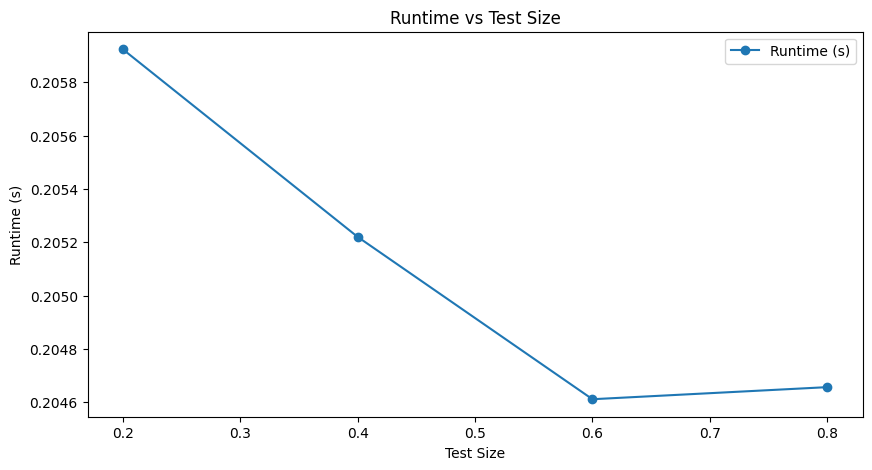

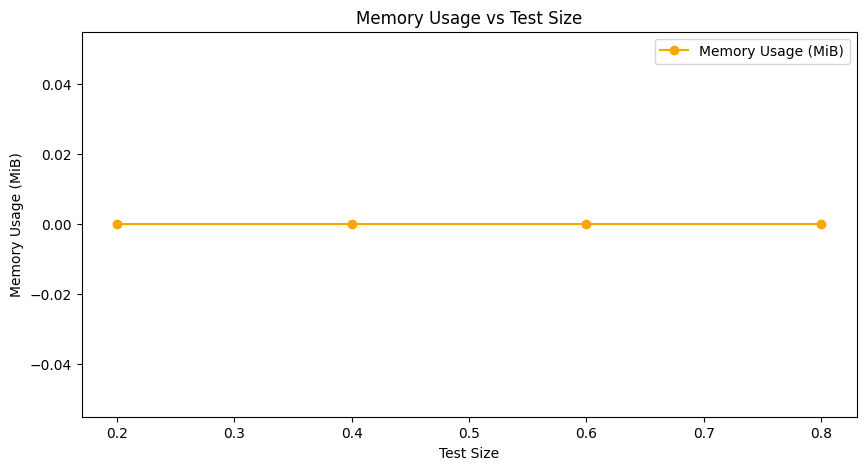

In [42]:
# extract data for visualization
test_sizes = [res[0] for res in benchmark_results]
runtimes = [res[1] for res in benchmark_results]
memory_usages = [res[2] for res in benchmark_results]
accuracies = [res[3] for res in benchmark_results]

# plot runtime
plt.figure(figsize=(10, 5))
plt.plot(test_sizes, runtimes, marker='o', label='Runtime (s)')
plt.title('Runtime vs Test Size')
plt.xlabel('Test Size')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

# plot memory usage
plt.figure(figsize=(10, 5))
plt.plot(test_sizes, memory_usages, marker='o', label='Memory Usage (MiB)', color='orange')
plt.title('Memory Usage vs Test Size')
plt.xlabel('Test Size')
plt.ylabel('Memory Usage (MiB)')
plt.legend()
plt.show()


### VISUALIZING THE ACCURACY

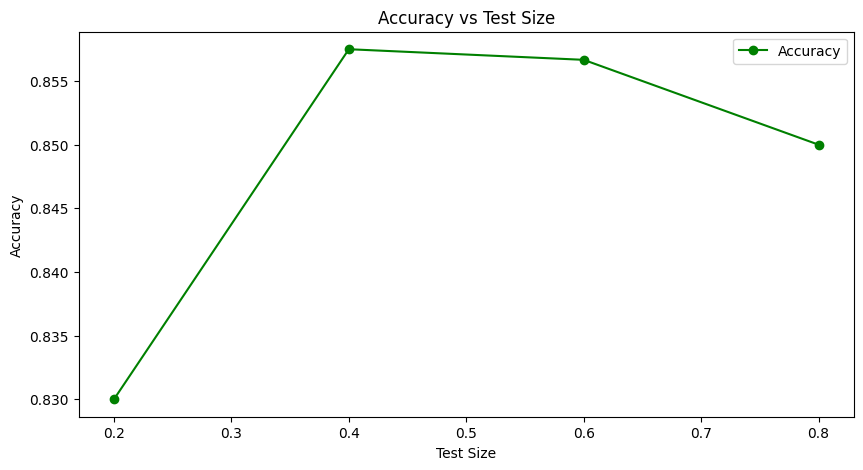

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(test_sizes, accuracies, marker='o', label='Accuracy', color='green')
plt.title('Accuracy vs Test Size')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**OVERVIEW OF IMPLEMENTATION**

*Synthetic Data Generation:*
*   The make_classification function generates a classification dataset with a specified number of samples and features. This ensures a controlled benchmarking environment, removing external variability from real-world data.

*Train-Test Splits:*
*   The code benchmarks the model across different test sizes (test_sizes list), simulating scenarios where the ratio of training to testing data varies. This highlights how dataset splits influence performance.

*Performance Metrics:*
*   Runtime: Captured using time.time() to measure the duration of the model.fit() and model.predict() steps.
*   Memory Usage: Measured before and after the fitting process using the memory_profiler library.
*   Accuracy: Evaluated using model.score(), which computes the proportion of correctly classified samples in the test set.

*Theoretical Complexities:*
*   Time Complexity:
𝑂
(
𝑛
samples
×
𝑛
features
×
𝑛
iter
)
O(n
samples
​
 ×n
features
​
 ×n
iter
​
 ), based on the optimization process during fitting.

*Space Complexity:*
*   List item
𝑂
(
𝑛
samples
×
𝑛
features
)
O(n
samples
​
 ×n
features
​
 ), derived from the storage requirements of the data matrix and learned coefficients.
These complexities are presented alongside empirical results, providing context for the observed behavior.




**STRENGTHS**

*Comprehensive Evaluation:*
*   The code captures multiple dimensions of performance—speed, memory efficiency, and predictive power—making the benchmarking results well-rounded.


*Theoretical and Empirical Integration*:

*   Including both the measured metrics and analytical complexities bridges the gap between theoretical expectations and real-world performance.

*Dynamic Test Case Handling*:

*   Varying the test sizes allows analysis of how the model performs under different training data proportions, which is valuable for understanding generalization and resource usage.
Scalability:

*   The parameterized design (e.g., n_samples, n_features) makes it easy to adapt the code for datasets of different sizes, enabling further exploration of scaling behavior.